<a href="https://colab.research.google.com/github/ikucherevsky/DeepLearning/blob/master/Fashion_MNIST_with_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

## Самостоятельная реализация свертки

In [ ]:
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
BATCH_SIZE=400

In [ ]:
transform1 = transforms.Compose([transforms.ToTensor()])

In [ ]:
transform = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),transforms.ToTensor()])

In [ ]:
train_dataset = datasets.FashionMNIST('.', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST('.', train=False, transform=transform1, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


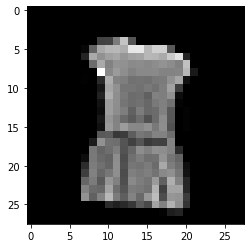

In [ ]:
plt.imshow(train_dataset[3][0].numpy().reshape(28,28), cmap='gray')

## Обучение на GPU

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cuda')

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
               % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))
        if test_acc > 0.93:
          print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
               % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))
          break


In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(2704, 1000),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 10),
    
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 16, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 16, 28, 28])
Layer Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)). X shape: torch.Size([1, 16, 26, 26])
Layer ReLU(). X shape: torch.Size([1, 16, 26, 26])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 16, 13, 13])
Layer Flatten(). X shape: torch.Size([1, 2704])
Layer Linear(in_features=2704, out_features=1000, bias=True). X shape: torch.Size([1, 1000])
Layer Dropout(p=0.5, inplace=False). X shape: torch.Size([1, 1000])
Layer ReLU(). X shape: torch.Size([1, 1000])
Layer Linear(in_features=1000, out_features=100, bias=True). X shape: torch.Size([1, 100])
Layer ReLU(). X shape: torch.Size([1, 100])
Layer Dropout(p=0.2, inplace=False). X shape: torch.Size([1, 100])
Layer Linear(in_features=100, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [ ]:
model = model.to(dev)

In [ ]:
lr, num_epochs = 0.001, 30
trainer = torch.optim.RMSprop(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.3370, train acc 0.883, test acc 0.916, time 19.3 sec
epoch 2, loss 0.2766, train acc 0.898, test acc 0.914, time 19.3 sec
epoch 3, loss 0.2699, train acc 0.901, test acc 0.917, time 19.1 sec
epoch 4, loss 0.2636, train acc 0.903, test acc 0.918, time 18.9 sec
epoch 5, loss 0.2620, train acc 0.904, test acc 0.916, time 19.1 sec
epoch 6, loss 0.2602, train acc 0.904, test acc 0.911, time 19.0 sec
epoch 7, loss 0.2576, train acc 0.906, test acc 0.916, time 19.1 sec
epoch 8, loss 0.2565, train acc 0.906, test acc 0.915, time 19.1 sec
epoch 9, loss 0.2546, train acc 0.906, test acc 0.913, time 19.3 sec
epoch 10, loss 0.2517, train acc 0.907, test acc 0.918, time 19.1 sec
epoch 11, loss 0.2482, train acc 0.908, test acc 0.921, time 19.1 sec
epoch 12, loss 0.2453, train acc 0.910, test acc 0.920, time 19.1 sec


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

In [ ]:
test_df = pd.DataFrame(columns = ['True','Predicted'])

In [ ]:
y_true = []
y_pred = []
for X, y in test_iter:
        X, y = X.to(dev), y.to(dev)
        y_p = model(X).argmax(axis=1)
        for i in range(BATCH_SIZE):

          y_true.append(y[i].item())
          y_pred.append(y_p[i].item())

In [ ]:
test_df['True'] = y_true
test_df['Predicted'] = y_pred

In [ ]:
errors = test_df[test_df['True'] != test_df['Predicted']]

In [ ]:
groupped_errors = errors.groupby('True').count().reset_index()

In [ ]:
import seaborn as sns

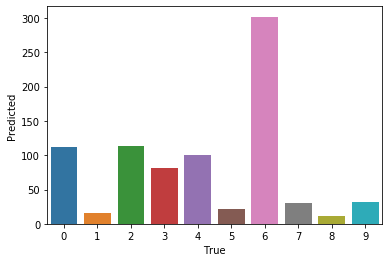

In [ ]:
sns.barplot(x='True',y='Predicted',data = groupped_errors)

                 0: "T-shirt/Top",Футболка,
                 
                 1: "Trouser","Брюки",
                 
                 2: "Pullover", «Пуловер»,
                 
                 3: "Dress",«Платье»,
                 
                 4: "Coat", «Пальто»,
                 
                 5: "Sandal", «Сандалии»
                 
                 6: "Shirt","Рубашка"
                 
                 7: "Sneaker",«Тапочки»,
                 
                 8: "Bag", «сумка»,
                 
                 9: "Ankle Boot","Ботильоны"


In [ ]:
errors[errors["True"] == 6].groupby('Predicted').count()

,True
Predicted,
0,129
2,67
3,23
4,77
8,6


In [ ]:
errors[errors['True'] == 2]

,True,Predicted
16,2,6
49,2,6
248,2,4
382,2,0
413,2,0
...,...,...
9574,2,6
9743,2,4
9852,2,6
9946,2,6


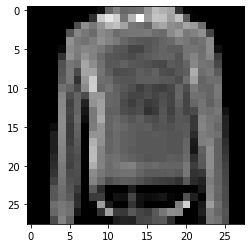

In [ ]:

plt.imshow(test_dataset[16][0].numpy().reshape(28,28), cmap='gray')
